In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
asset=yf.download('BTC-USD', start="2022-01-01", end="2024-07-20")

[*********************100%%**********************]  1 of 1 completed


In [3]:
asset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-01,46311.746094,47827.312500,46288.484375,47686.812500,47686.812500,24582667004
2022-01-02,47680.925781,47881.406250,46856.937500,47345.218750,47345.218750,27951569547
2022-01-03,47343.542969,47510.726562,45835.964844,46458.117188,46458.117188,33071628362
2022-01-04,46458.851562,47406.546875,45752.464844,45897.574219,45897.574219,42494677905
2022-01-05,45899.359375,46929.046875,42798.222656,43569.003906,43569.003906,36851084859


In [4]:
asset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 931 entries, 2022-01-01 to 2024-07-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       931 non-null    float64
 1   High       931 non-null    float64
 2   Low        931 non-null    float64
 3   Close      931 non-null    float64
 4   Adj Close  931 non-null    float64
 5   Volume     931 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 50.9 KB


In [16]:
pd.options.mode.chained_assignment = None

## 報酬率採用對數Log Return，可方便線性相加

In [17]:
asset['returns']=np.log(asset['Close']/asset['Close'].shift(1))

<Axes: >

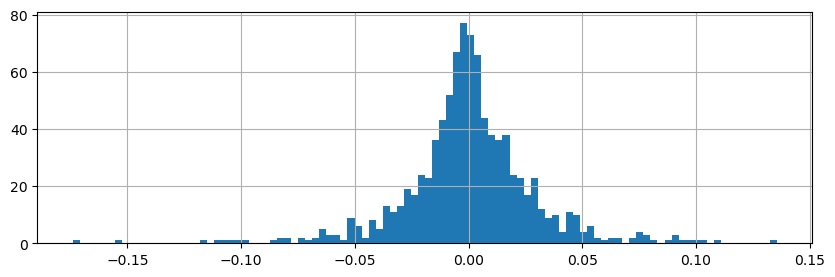

In [18]:
asset['returns'].hist(bins=100, figsize=(10,3))

## MA均線算法定義，簡單移動平均、指數移動平均
### EMA=EMA(N) = 2 * X / (N+1) + (N-1) * EMA(N-1)/(N+1)
### SMA=SMA(N) = [P1+P2+P3+........+P(N-1)+P(N)]/N

In [19]:
# EMA
asset['EMA1']=asset['Close'].ewm(span=12).mean()
asset['EMA2']=asset['Close'].ewm(span=26).mean()

In [20]:
# SMA
asset['SMA1']=asset['Close'].rolling(42).mean()
asset['SMA2']=asset['Close'].rolling(252).mean()

## EMA策略回測

<Axes: xlabel='Date'>

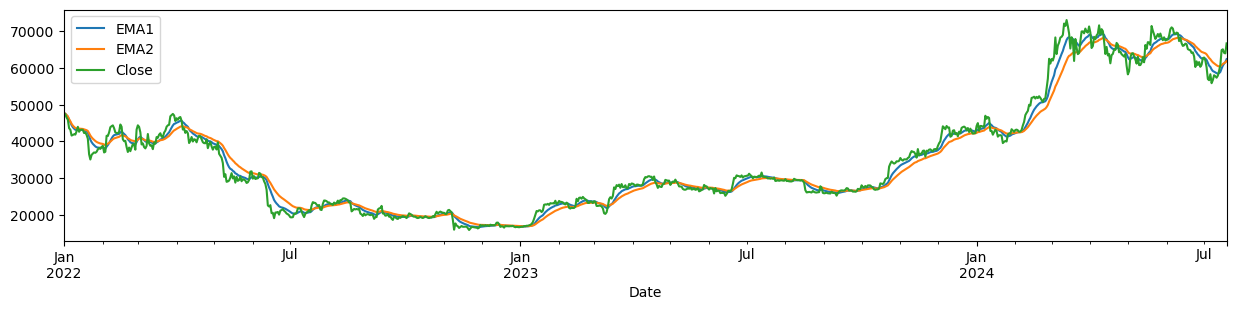

In [21]:
#Plot EMA Strats
asset[['EMA1','EMA2','Close']].plot(figsize=(15,3))

## EMA買賣信號判定，用布林值判定隨時間變化的交易

In [22]:
asset['signal']=np.where(asset['EMA1']>asset['EMA2'], 1, -1)

<Axes: title={'center': 'Market Position'}, xlabel='Date'>

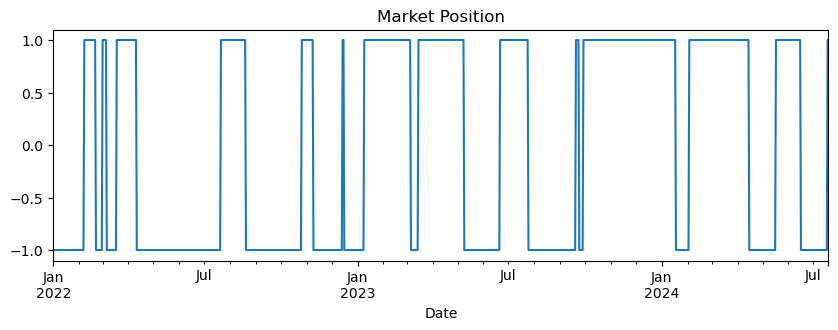

In [24]:
asset['signal'].plot(ylim=[-1.1, 1.1], title='Market Position', figsize=(10,3))

In [25]:
asset['returns']=np.log(asset['Close']/asset['Close'].shift(1))

In [26]:
asset['EMA strategy']=asset['signal'].shift(1)*asset['returns']

In [27]:
asset[['returns','EMA strategy']].sum()

returns         0.335702
EMA strategy    0.445099
dtype: float64

In [28]:
asset[['returns','EMA strategy']].sum().apply(np.exp)

returns         1.398923
EMA strategy    1.560645
dtype: float64

<Axes: >

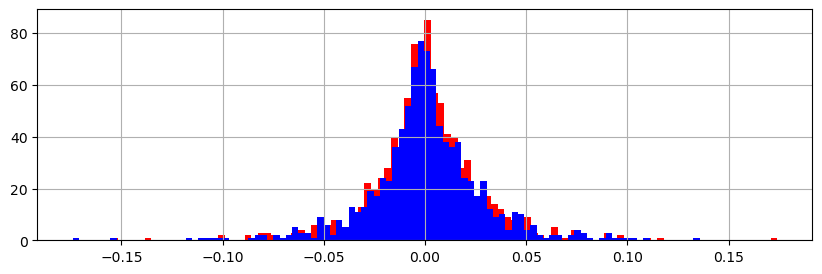

In [32]:
asset['EMA strategy'].hist(bins=100, figsize=(10,3), color='r')
asset['returns'].hist(bins=100, figsize=(10,3), color='b')

<Axes: xlabel='Date'>

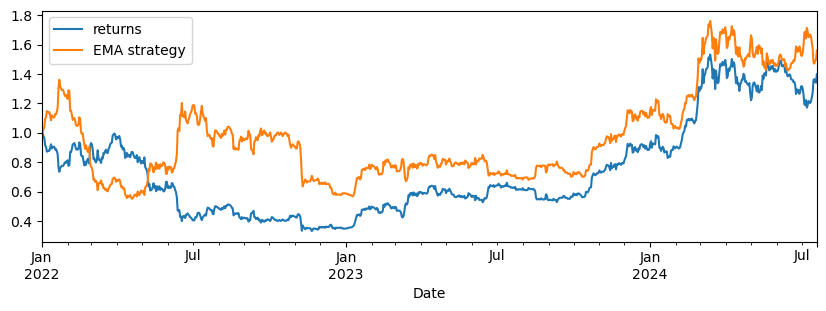

In [33]:
asset[['returns','EMA strategy']].cumsum().apply(np.exp).plot(figsize=(10,3))

## EMA策略的最大回撤MDD 跟最大回撤區間

In [148]:
asset['cumret']=asset['EMA strategy'].cumsum().apply(np.exp)

In [150]:
asset['cummax']=asset['cumret'].cummax()

<Axes: xlabel='Date'>

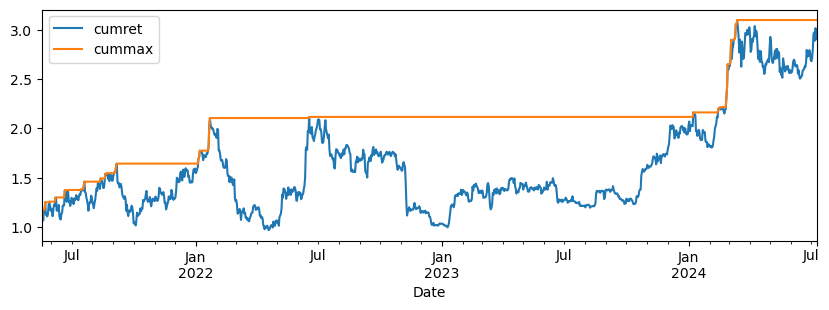

In [151]:
asset[['cumret','cummax']].dropna().plot(figsize=(10,3))

In [152]:
drawdown=asset['cummax']-asset['cumret']

In [153]:
drawdown.max()

1.135834704060298

In [154]:
# drawdown period
temp=drawdown[drawdown==0]

In [155]:
periods=(temp.index[1:].to_pydatetime()-temp.index[:-1].to_pydatetime())

In [156]:
periods.max()

datetime.timedelta(days=569)

---

## SMA策略回測

<Axes: xlabel='Date'>

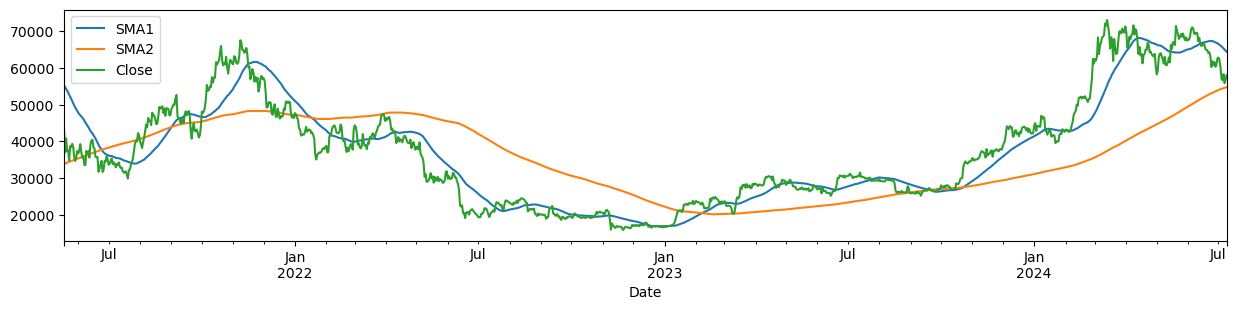

In [158]:
asset[['SMA1','SMA2','Close']].plot(figsize=(15,3))

## SMA買賣信號判定，用布林值判定隨時間變化的交易

In [136]:
asset['position']=np.where(asset['SMA1']>asset['SMA2'], 1, -1)

In [137]:
asset.dropna(inplace=True)

<Axes: title={'center': 'Market Position'}, xlabel='Date'>

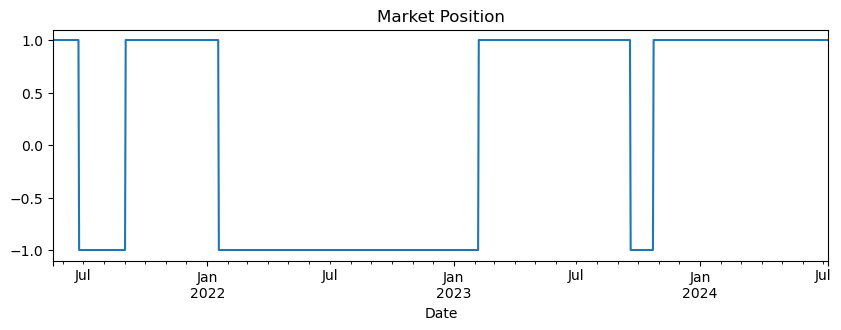

In [138]:
asset['position'].plot(ylim=[-1.1, 1.1], title='Market Position', figsize=(10,3))

In [139]:
# Strategy Returns
asset['SMA strategy']=asset['position'].shift(1)*asset['returns']

In [140]:
asset[['returns','SMA strategy']].sum()

returns         0.286979
SMA strategy    0.167058
dtype: float64

In [141]:
#Gross Performance
asset[['returns','SMA strategy']].sum().apply(np.exp)

returns         1.332396
SMA strategy    1.181823
dtype: float64

<Axes: xlabel='Date'>

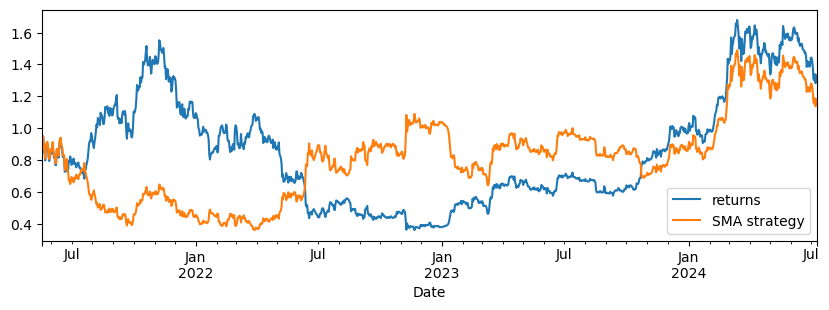

In [142]:
asset[['returns','SMA strategy']].cumsum().apply(np.exp).plot(figsize=(10,3))

## SMA策略的最大回撤MDD 跟最大回撤區間

In [143]:
asset['cumret']=asset['SMA strategy'].cumsum().apply(np.exp)

In [144]:
asset['cummax']=asset['cumret'].cummax()

<Axes: xlabel='Date'>

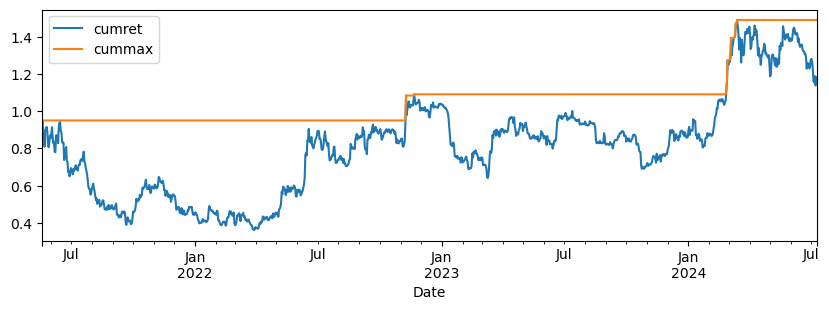

In [145]:
asset[['cumret','cummax']].dropna().plot(figsize=(10,3))

In [146]:
drawdown=asset['cummax']-asset['cumret']

In [147]:
drawdown.max()

0.5877532585693972

In [115]:
# drawdown period
temp=drawdown[drawdown==0]

In [116]:
periods=(temp.index[1:].to_pydatetime()-temp.index[:-1].to_pydatetime())

In [117]:
periods[12:15]

array([datetime.timedelta(days=1), datetime.timedelta(days=1),
       datetime.timedelta(days=2)], dtype=object)

In [118]:
periods.max()

datetime.timedelta(days=1065)